In [1]:
import statsmodels.api as sm
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

In [47]:
N = 50
sample = stats.uniform.rvs(size=N*5)*2 - 1
sample = sample.reshape((N, 5))
eta = np.zeros((N))

C = [2, 3, -2, 1, 1, -1]

for i in range(N):
    eta[i] = np.random.normal(C[0] + C[1:] @ sample[i].T, 1.5)

In [48]:
def rss0(x):
    return sum([(a - np.mean(x))**2 for a in x])

def regression(psi, eta):
    F = psi.T @ psi
    F_inv = np.linalg.inv(F)
    b = (F_inv @ psi.T) @ eta.T
    e = eta - (psi @ b.T).T
    RSSy = e @ e.T
    RSS0y = rss0(eta)

    R = (RSS0y - RSSy)/RSS0y
    
    delta = [b[i]*((N - len(psi[0]))/(RSSy*F_inv[i][i]))**(1/2) \
             for i in range(len(psi[0]))]
    b_p_value = 2*(1 - stats.t.cdf(np.abs(delta), N - np.shape(psi)[1]))
    
    return b, b_p_value, RSSy, RSS0y, R

## a)

In [49]:
RSS0_xi = np.zeros(5)
RSS_xi = np.zeros(5)
R_xi = np.zeros(5)

for i in range(5):
    psi_xi = np.copy(sample)
    for j in range(N):
        psi_xi[j][i] = 1
    
    RSS_xi[i] = regression(psi_xi, sample.T[i])[2]
    RSS0_xi[i] = regression(psi_xi, sample.T[i])[3]
    R_xi[i] = (RSS0_xi[i] - RSS_xi[i])/RSS0_xi[i]
    
    
print("R_xi^2 =", np.around((R_xi**2), decimals=3))

R_xi^2 = [0.009 0.006 0.001 0.001 0.   ]


все значения меньше 0.7 => мультиколлинеарности нет

## b)

In [50]:
tmp = np.copy(sample)
psi = np.empty((N, 6))

for i in range(N):
     psi[i] = np.insert(tmp[i], 0, 1)
        
b, b_p_value, RSSy, RSS0y, R = regression(psi, eta)

F = psi.T @ psi
F_inv = np.linalg.inv(F)
e = (eta - psi @ b.T).T

print(" b =", np.around((b), decimals=3))
print(" p-value =", np.around((b_p_value), decimals=3))

 b = [ 1.757  3.017 -2.143  1.582  0.868 -0.503]
 p-value = [0.    0.    0.    0.    0.007 0.115]


p-value при b3 > 0.05 => 3 - не значим

## с)

In [51]:
print("RSS0y =", "%.3f" % RSS0y)
print("RSSy =", "%.3f" % RSSy)
print("R =", "%.3f" % R, " - коэффициент детерминации")

delta_R = R/(1 - R)*(N - 6)/5

R_p_value = 1 - stats.f.cdf(np.abs(delta_R), 5, N - 6)
print("R p-value =", "%.3f" % R_p_value)

RSS0y = 442.308
RSSy = 72.083
R = 0.837  - коэффициент детерминации
R p-value = 0.000


p-value < 0.05 => отвергаем теорию о незначимости регрессии

## d)

In [52]:
x0 = np.array([0, 0, 0, 0, 0])
psi_x0 = np.insert(x0, 0, 1)

eta0 = np.random.normal(C[0] + C[1:] @ x0.T, 1.5)
print("eta0 =", "%.3f" % eta0)

y0 = b[0] + b[1:] @ x0.T
print("y0 =", "%.3f" % y0)

delta = stats.t.ppf(1.95/2, N - 6)*\
(1 + (psi_x0 @ F_inv) @ psi_x0.T)**(1/2)*(RSSy/(N - 6))**(1/2)

print('[', "%.3f" % (y0 - delta),':', "%.3f" % (y0 - delta), \
      "] - дов. интервал\n")

eta0 = 3.168
y0 = 1.757
[ -0.853 : -0.853 ] - дов. интервал



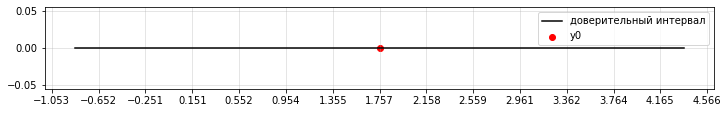

In [53]:
fig, ax = plt.subplots(1, 1, figsize = (12,1.5))
ax.plot([y0 - delta, y0 + delta], [0,0], color = 'k', label = "доверительный интервал")
ax.set_xticks(np.linspace(y0 - delta-0.2, y0 + delta+0.2, 15))
ax.scatter(y0, 0, color = 'red',  label="y0")
ax.grid(alpha = 0.4)
ax.legend()

## e)

In [54]:
I=0
for i in range(N):
    for j in range (i + 1, N):
        if(e[i] > e[j]):
            I += 1

delta = (I - N*(N - 1)/4)/(N**3/36)**(1/2)

p_value = 2*(1 - stats.norm.cdf(abs(delta)))
print(" p-value =", "%.3f" % p_value)

 p-value = 0.754


p-value > 0.05 => нет оснований отвергнуть предположение о независимости ошибок измерения

## f)

In [55]:
M = 5000
D = np.zeros(M)
s = np.zeros((M,N))
sigma_est = np.mean((e - np.mean(e))**2)**(1/2)

def sup(z, sigma):
    w = np.zeros(N)
    
    ecdf = sm.distributions.ECDF(z)
    u = ecdf(z)
    v = stats.norm.cdf(z, 0, sigma)
    w[0] = np.max((v[0], np.abs(v[0] - u[0])))
    for i in range(1, N):
        w[i] = np.max((np.abs(v[i] - u[i]), np.abs(v[i] - u[i - 1])))
    return np.max(w)

for i in range(M):
    for j in range(N):
        a = np.random.uniform()
        s[i][j] = stats.norm.ppf(a, 0, sigma_est)
    sigma = np.mean((s[i] - np.mean(s[i]))**2)**(1/2)
    D[i] = sup(s[i], sigma)
    
D = np.sort(D)     
d = sup(e, sigma_est)
p_value = 0

for i in range(M):
    if (D[i] > d):
        p_value = 1 - i/M
        break
        
print("p-value =", "%.3f" % p_value)

p-value = 0.603


p-value > 0.05 => нет оснований отвергнуть гипотезу о нормальном распределении ошибок

In [56]:
var_est = np.var(e)
mean_est = np.mean(e)

n_dots = 100
points = np.linspace(np.min(e), np.max(e), n_dots)

F_emp = [np.sum(e<el)/N for el in np.sort(e)]
F_acc = [stats.norm.cdf(i, mean_est, var_est) for i in np.sort(e)]

delta_acc = N**0.5*max(list(map(lambda x,y: abs(x-y), F_acc, F_emp)))

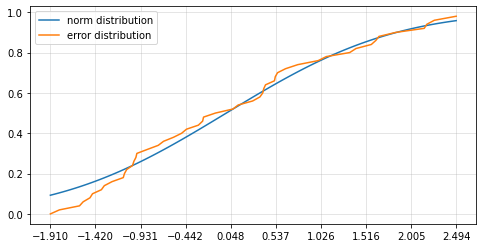

In [57]:
fig, ax = plt.subplots(1, 1, figsize = (8,4))
ax.plot(points, stats.norm.cdf(points, mean_est, var_est), label = "norm distribution")
ax.plot(np.sort(e), F_emp, label = "error distribution")
ax.set_xticks(np.linspace(min(e), max(e), 10))
ax.grid(alpha = 0.4)
ax.legend()
None

## g)

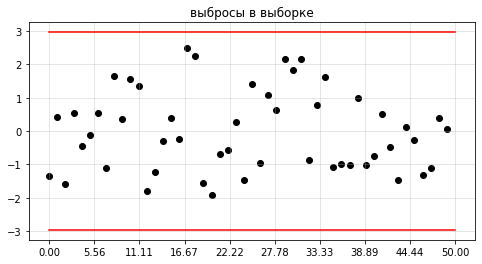

In [58]:
sigma_out = np.median(abs(e))/0.675

fig, ax = plt.subplots(1, 1, figsize = (8,4))
ax.scatter(np.arange(N), e, color = 'k')
ax.plot([0, 50], [-2*sigma_out, -2*sigma_out], color = 'r')
ax.plot([0, 50], [2*sigma_out, 2*sigma_out], color = 'r')

ax.set_xticks(np.linspace(0, N, 10))
ax.grid(alpha = 0.4)
ax.set_title("выбросы в выборке")
None

## h)

In [59]:
RSS_CV = 0

for i in range(N):    
    tmp = np.delete(sample, i, axis = 0)
    eta_CV = np.delete(eta, i, axis = 0)
    psi_CV = np.empty([N - 1, 6])
    for i in range(N - 1):
         psi_CV[i] = np.insert(tmp[i], 0, 1)

    F_CV = psi_CV.T @ psi_CV
    F_inv_CV = np.linalg.inv(F_CV)
    b_CV = (F_inv_CV @ psi_CV.T) @ eta_CV.T
    RSS_CV += (eta[i] - b_CV[0] - b_CV[1:] @ sample[i])**2

R_CV = (RSS0y - RSS_CV)/RSS0y
print("R_CV =", "%.3f" % R_CV)

R_CV = 0.981


## i)

In [60]:
x = sample[0]
y = np.array([np.random.normal(C[0] + C[1:] @ x.T, 1.5) \
              for i in range(5)])

delta = (N - 6)*((y - np.mean(y)) @ (y - np.mean(y)).T)/RSSy/4
p_value = 1 - stats.f.cdf(np.abs(delta), 4, 5)

print("p-value =", "%.3f" % p_value)

p-value = 0.558


P-value > 0.05 => модель регрессии адекватна

## j)

In [61]:
print(np.argmax(b_p_value) - 1, 'кси наименее значим')

psi_simp = np.delete(psi, np.argmax(b_p_value), axis = 1)
b_simp, b_p_value_simp, RSSy_simp, RSS0y_simp, R_simp = \
    regression(psi_simp, eta)
print("\nДля упрощенной модели:")
print("b =", np.around((b_simp), decimals=3))
print("p-value =", np.around((b_p_value_simp), decimals=3))

delta_R_simp = R_simp/(1 - R_simp)*(N - 5)/4
p_value_simp = 1 - stats.f.cdf(np.abs(delta_R_simp), 4, N - 5)

print("p-value =", "%.3f" % p_value_simp)

print("\nСравним две регрессии:")
delta_regression = (RSSy_simp - RSSy)/RSSy*(N - 6)
p_value = 1 - stats.f.cdf(np.abs(delta), 1, N - 6)
print("p-value =", "%.3f" % p_value)

4 кси наименее значим

Для упрощенной модели:
b = [ 1.698  3.078 -2.095  1.565  0.876]
p-value = [0.    0.    0.    0.    0.007]
p-value = 0.000

Сравним две регрессии:
p-value = 0.366


## k)

In [62]:
M = 1000
B_delta = np.empty(M)

for i in range(M): 
    psi1 = np.empty((N,6))
    eta1 = np.empty(N)
    for j in range(N):
        q = np.random.choice(range(N))
        psi1[j] = psi[q]
        eta1[j] = eta[q]
        
    b1, b1_p_v, RSSy1, RSS0y1, Ry1 = regression(psi1, eta1)
    b2, b2_p_v, RSSy2, RSS0y2, Ry2 = \
    regression(np.delete(psi1, np.argmax(b1_p_v), axis = 1), eta1)
    
    B_delta[i] = (RSSy2/RSSy1 - 1)*(N - 6)
    
B_delta = np.sort(B_delta)
p_value = 0

for i in range(M):
    if (B_delta[i] > delta_regression):
        p_value = 1 - i/M
        break
        
print("p-value =", "%.3f" % p_value)

p-value = 0.465
